# N-Queens Solver with Constraint Satisfaction 

## I. Introduction
Constraint Satisfaction is a technique for solving problems by expressing limits on the values of each variable in the solution with mathematical constraints. In this project, a symbolic math library is used to explicitly construct binary constraints and then use Backtracking to solve the N-queens problem. The N-queens problem is to place N queens on a standard NxN chessboard such that none of the queens are in "check" (i.e., no two queens occupy the same row, column, or diagonal). Using symbolic constraints should make it easier to visualize and reason about the constraints (especially for debugging), but comes with a performance penalty.

This project uses symbolic math library `Sympy`. Information about this library can be found in this [link](http://www.sympy.org/en/index.html), and examples using symbols (sympy.Symbol), functions (sympy.Function), and expressions (sympy.Expr) from `Sympy` can be found in `Sympy_Intro.ipynb`.

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt

from util import constraint, displayBoard
from sympy import *
from IPython.display import display
init_printing()
%matplotlib inline

## II. Representing the N-Queens Problem
There are many acceptable ways to represent the N-queens problem, but one convenient way is to recognize that one of the constraints (either the row or column constraint) can be enforced implicitly by the encoding.  If we represent a solution as an array with N elements, then each position in the array can represent a column of the board, and the value at each position can represent which row the queen is placed on.

In this encoding, we only need a constraint to make sure that no two queens occupy the same row, and one to make sure that no two queens occupy the same diagonal.

### Define Symbolic Expressions for the Problem Constraints
Before implementing the board class, we need to construct the symbolic constraints that will be used in the CSP.  Declare any symbolic terms required, and then declare two generic constraint generators:
- `diffRow` - generate constraints that return True if the two arguments do not match
- `diffDiag` - generate constraints that return True if two arguments are not on the same diagonal (if the difference in the number of rows and the number of columns match, then queens in two columns are on the same diagonal)

Both generators should produce binary constraints (i.e., each should have two free symbols) once they're bound to specific variables in the CSP. For example, Eq((a + b), (b + c)) is not a binary constraint, but Eq((a + b), (b + c)).subs(b, 1) _is_ a binary constraint because one of the terms has been bound to a constant, so there are only two free variables remaining. 

In [5]:
# Declare any required symbolic variables
rows = symbols('X:2')
col_diff = Symbol('Y')

# Define diffRow and diffDiag constraints
diffRow = constraint('diffRow', Ne(rows[0], rows[1]))
diffDiag = constraint('diffDiag', Ne(abs(rows[0] - rows[1]), col_diff))

In [13]:
# Test diffRow and diffDiag
_x = symbols("x:3")

# generate a diffRow instance for testing
diffRow_test = diffRow.subs({rows[0]: _x[0], rows[1]: _x[1]})

assert(len(diffRow_test.free_symbols) == 2)
assert(diffRow_test.subs({_x[0]: 0, _x[1]: 1}) == True)
assert(diffRow_test.subs({_x[0]: 0, _x[1]: 0}) == False)
assert(diffRow_test.subs({_x[0]: 0}) != False)  # partial assignment is not false
print("Passed all diffRow tests.")

# generate a diffDiag instance for testing
diffDiag_test = diffDiag.subs({rows[0]: _x[0], rows[1]: _x[2], col_diff: 2})

assert(len(diffDiag_test.free_symbols) == 2)
assert(diffDiag_test.subs({_x[0]: 0, _x[2]: 2}) == False)
assert(diffDiag_test.subs({_x[0]: 0, _x[2]: 0}) == True)
assert(diffDiag_test.subs({_x[0]: 0}) != False)  # partial assignment is not false
print("Passed all diffDiag tests.")

Passed all diffRow tests.
Passed all diffDiag tests.


### The N-Queens CSP Class
Implement the CSP class as described above, with constraints to make sure each queen is on a different row and different diagonal than every other queen, and a variable for each column defining the row that containing a queen in that column.

In [21]:
class NQueensCSP:
    """CSP representation of the N-queens problem
    
    Parameters
    ----------
    N : Integer
        The side length of a square chess board to use for the problem, and
        the number of queens that must be placed on the board
    """
    def __init__(self, N):
        _vars = symbols('x:%d' % N)
        _domain = set(range(N))
        self.size = N
        self.variables = _vars
        self.domains = {v: _domain for v in _vars}
        self._constraints = {x: set() for x in _vars}

        # add constraints - for each pair of variables xi and xj, create
        # a diffRow(xi, xj) and a diffDiag(xi, xj) instance, and add them
        # to the self._constraints dictionary keyed to both xi and xj;
        # (i.e., add them to both self._constraints[xi] and self._constraints[xj])
        for i in range(N):
            for j in range(N):
                if i < j:
                    xi = _vars[i]
                    xj = _vars[j]
                    diffRow_constraint = diffRow.subs({rows[0]: xi, 
                                                       rows[1]: xj})
                    diffDiag_constraint = diffDiag.subs({rows[0]: xi, 
                                                         rows[1]: xj, 
                                                         col_diff: j-i})
                    self._constraints[xi].update([diffRow_constraint, diffDiag_constraint])
                    self._constraints[xj].update([diffRow_constraint, diffDiag_constraint])  
    
    @property
    def constraints(self):
        """Read-only list of constraints -- cannot be used for evaluation """
        constraints = set()
        for _cons in self._constraints.values():
            constraints |= _cons
        return list(constraints)
    
    def is_complete(self, assignment):
        """An assignment is complete if it is consistent, and all constraints
        are satisfied.
        
        Parameters
        ----------
        assignment : dict(sympy.Symbol: Integer)
            An assignment of values to variables that have previously been checked
            for consistency with the CSP constraints
        """
        return len(assignment) == self.size
    
    def is_consistent(self, var, value, assignment):
        """Check consistency of a proposed variable assignment
                
        self._constraints[x] returns a set of constraints that involve variable `x`.
        An assignment is consistent unless the assignment it causes a constraint to
        return False (partial assignments are always consistent).
        
        Parameters
        ----------
        var : sympy.Symbol
            One of the symbolic variables in the CSP
            
        value : Numeric
            A valid value (i.e., in the domain of) the variable `var` for assignment

        assignment : dict(sympy.Symbol: Integer)
            A dictionary mapping CSP variables to row assignment of each queen
            
        """
        for c in self._constraints[var]:
            constraint = c.subs(var, value)
            constraint = constraint.subs(assignment)
            if not constraint:
                return False
        return True
        
    def inference(self, var, value):
        """Perform logical inference based on proposed variable assignment
        
        Returns an empty dictionary by default; function can be overridden to
        check arc-, path-, or k-consistency; returning None signals "failure".
        
        Parameters
        ----------
        var : sympy.Symbol
            One of the symbolic variables in the CSP
        
        value : Integer
            A valid value (i.e., in the domain of) the variable `var` for assignment
            
        Returns
        -------
        dict(sympy.Symbol: Integer) or None
            A partial set of values mapped to variables in the CSP based on inferred
            constraints from previous mappings, or None to indicate failure
        """
        
        return {}
    
    def show(self, assignment):
        """Display a chessboard with queens drawn in the locations specified by an
        assignment
        
        Parameters
        ----------
        assignment : dict(sympy.Symbol: Integer)
            A dictionary mapping CSP variables to row assignment of each queen
            
        """
        locations = [(i, assignment[j]) for i, j in enumerate(self.variables)
                     if assignment.get(j, None) is not None]
        displayBoard(locations, self.size)

## III. Backtracking Search
Implement the [backtracking search](https://github.com/aimacode/aima-pseudocode/blob/master/md/Backtracking-Search.md) algorithm.

In [22]:
def select(csp, assignment):
    """Choose an unassigned variable in a constraint satisfaction problem """
    for var in csp.variables:
        if var not in assignment:
            return var
    return None

def order_values(var, assignment, csp):
    """Select the order of the values in the domain of a variable for checking during search;
    the default is lexicographically.
    """
    return csp.domains[var]

def backtracking_search(csp):
    """Helper function used to initiate backtracking search """
    return backtrack({}, csp)

def backtrack(assignment, csp):
    """Perform backtracking search for a valid assignment to a CSP
    
    Parameters
    ----------
    assignment : dict(sympy.Symbol: Integer)
        An partial set of values mapped to variables in the CSP
        
    csp : CSP
        A problem encoded as a CSP. Interface should include csp.variables, csp.domains,
        csp.inference(), csp.is_consistent(), and csp.is_complete().
    
    Returns
    -------
    dict(sympy.Symbol: Integer) or None
        A partial set of values mapped to variables in the CSP, or None to indicate failure
    """
    if csp.is_complete(assignment):
        return assignment
    
    var = select(csp, assignment)
    for val in order_values(var, assignment, csp):
        if csp.is_consistent(var, val, assignment):
            assignment[var] = val
            inferences = csp.inference(var, val)
            if inferences is not None:
                assignment.update(inferences)
                result = backtrack(assignment, csp)
                if result:
                    return result
    return None # failure

### Solve the CSP
With backtracking implemented, now you can use it to solve instances of the problem. We've started with the classical 8-queen version, but you can try other sizes as well.  Boards larger than 12x12 may take some time to solve because sympy is slow in the way its being used here, and because the selection and value ordering methods haven't been implemented.  See if you can implement any of the techniques in the AIMA text to speed up the solver!

CSP problems have variables, each variable has a domain, and the problem has a list of constraints.
Variables for the 8-Queens CSP:


Domain for x0:


Constraints for x0:


Solving 8-Queens CSP...
Solution found:
{x7: 3, x5: 4, x6: 0, x4: 7, x0: 5, x2: 6, x3: 1, x1: 2}


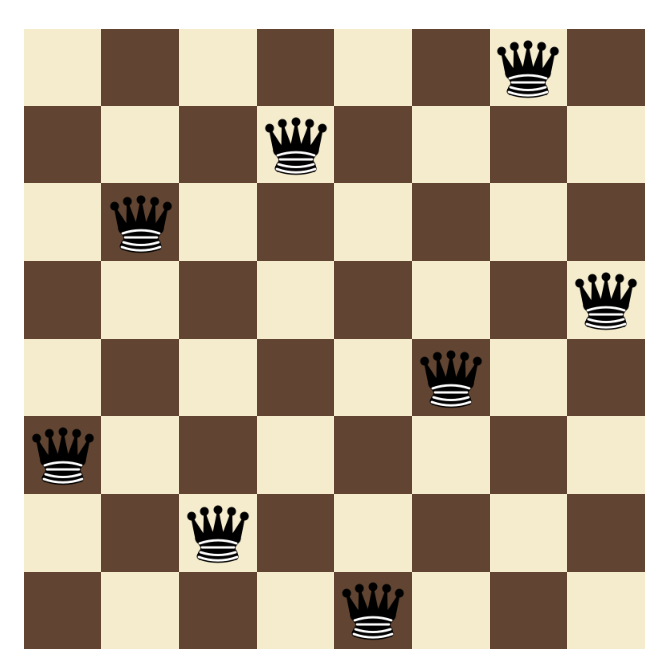

In [25]:
num_queens = 8
csp = NQueensCSP(num_queens)
var = csp.variables[0]
print("CSP problems have variables, each variable has a domain, and the problem has a list of constraints.")
print("Variables for the 8-Queens CSP:")
display(csp.variables)
print("Domain for {}:".format(var))
display(csp.domains[var])
print("Constraints for {}:".format(var))
display(csp._constraints[var])

print("Solving 8-Queens CSP...")
assn = backtracking_search(csp)
if assn is not None:
    print("Solution found:\n{!s}".format(assn))
    csp.show(assn)
else:
    print("No solution found.")